<a href="https://colab.research.google.com/github/akiFQC/colaboratry_DNN_API_collection/blob/master/dream_maker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flask web application of deep dream by VGG19

In [1]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-10-21 04:59:07--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.223.119.4, 52.4.11.55, 52.71.61.108, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.223.119.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  16.7MB/s    in 0.8s    

2019-10-21 04:59:08 (16.7 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
from flask import Flask, render_template, send_from_directory, request, redirect, url_for

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import Variable
from chainer.backends import cuda

import numpy as np
import pandas as pd
import cupy as cp

import os, sys
import pprint
import time
import urllib.error
import urllib.request
from PIL import Image
import io
import random, string
from matplotlib import pyplot as plt



In [0]:
def download_file(url, dst_path):
    try:
        with urllib.request.urlopen(url) as web_file:
            data = web_file.read()
            with open(dst_path, mode='wb') as local_file:
                local_file.write(data)
    except urllib.error.URLError as e:
        print(e)

In [0]:
def reverse_img(image):
    image = image.transpose((1, 2, 0))
   
    image = image + np.array([103.939, 116.779, 123.68], dtype="float32")
    image =np.clip(image, 0, 255)
    return image[:, :, [2, 1, 0]].astype("int")

In [0]:
def randomname(n):
    randlst = [random.choice(string.ascii_letters + string.digits) for i in range(n)]
    return ''.join(randlst)

In [0]:
html = """

<!DOCTYPE html>
<html>
<head>
<meta charset="utf-8" />
<title>Deep Dream with VGG19</title>
</head>
<body>
<h1>Deep Dream</h1>
I recommend the size of an image you upload  is 224 x 224. 
<form action="/post" method="post" enctype="multipart/form-data">
    <p><input type="file" name="uploadFile"/></p>
    <p><input type="submit" value="send"/></p>
</form>

{% if ulr_adv_Image %}

    <p>Original Image</p>
    <p><img src="{{ ulr_original_Image }}"></p>
    <p>Dream Image</p>
    <p><img src="{{ ulr_adv_Image }}"></p>

{% endif %}

</body>
</html>

"""

In [0]:
#Saving html file
if not os.path.isdir( "templates" ):
    os.makedirs( "templates" )
with open("templates/index.html", mode='w') as f:
    f.write(html)
    
#Making tmp folder to use temporarily stored
if not os.path.isdir( "tmp" ):
    os.makedirs( "tmp" )

In [8]:
model =  L.VGG19Layers()
model.to_gpu(0)
model.disable_update()

Now loading caffemodel (usually it may take few minutes)


In [0]:
def deep_dream(x, model, num_iter=50):
    layers = model.available_layers[-2:-1]
    print(layers)
    x_dream = Variable(x)

    lr = cp.array([7],dtype ="float32"  )

    log_loss = []

    for epoch in range(num_iter):

        result = model(x_dream, layers=layers)
        loss = 0
        for layer in layers:
            loss -= F.mean(result[layer])

        grad = chainer.grad([loss],[x_dream])[0]

        x_dream = x_dream -  lr *F.sign(grad)

        # clip
        x_dream = F.clip(x_dream,  -123.0,  144.0)


        if epoch %5==3:
            lr = lr *0.8
    return x_dream.data

tmp/Gro%C3%9Fer_Schweizer_Sennenhund.jpg
['fc8']


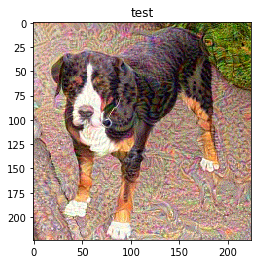

In [10]:
# テスト用
url = "https://upload.wikimedia.org/wikipedia/commons/5/5c/Gro%C3%9Fer_Schweizer_Sennenhund.jpg"

data_path =  "tmp/" + url.split("/")[-1]
print(data_path)
download_file( url, data_path)

# メインとなる処理
def deepdreem_from_path(path, model, num_iter=20, ord_norm = cp.inf, epsilon=3,  lr = 1):
    if ord_norm == float("inf") or ord_norm is np.inf:
        ord_norm = cp.inf
    img = Image.open(path)
    X_img =  L.model.vision.vgg.prepare(img)

    X_img = X_img[np.newaxis]
    x_cp = cp.asarray(X_img)
    x_cp = cuda.to_gpu(x_cp)
    
    dream_img = deep_dream(x_cp, model=model, num_iter=num_iter)
    dream_img = reverse_img(cp.asnumpy(dream_img[0]))
    return dream_img
    

# テスト
ad_img = deepdreem_from_path(data_path, model)
plt.imshow(ad_img)
plt.title("test")
plt.show()

    

In [0]:
app = Flask(__name__)

@app.route("/")
def index():
    return render_template( "index.html" )

@app.route('/post', methods=['POST'])
def post():
    try:
        uploadFile = request.files['uploadFile']
    except:
        return redirect(url_for('index'))
    
    file_name_ori= randomname(24) + ".jpg"
    
    url_original_image = "tmp/" + file_name_ori
    url_adv_image = "tmp/" + file_name_ori.split(".")[0] +"_adversarialexample.jpg"
    uploadFile.save("tmp/" + file_name_ori)
    
    
    dr_img= deepdreem_from_path(url_original_image, model=model)
    pilImg = Image.fromarray(np.uint8(dr_img))
    pilImg.save(url_adv_image)
    
    

    return render_template( "index.html",
                                        ulr_original_Image = url_original_image,
                                        ulr_adv_Image = url_adv_image
                                        )
    
@app.route('/tmp/<filename>')
def uploaded_file(filename):
    return send_from_directory("./tmp", filename)
    


In [0]:
!cd ~
! ls
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


if __name__ == '__main__':
    app.run(port=6006)

ngrok  ngrok-stable-linux-amd64.zip  sample_data  templates  tmp
https://8ca12cd9.ngrok.io
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:6006/ (Press CTRL+C to quit)
127.0.0.1 - - [21/Oct/2019 05:00:34] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Oct/2019 05:00:34] "GET /favicon.ico HTTP/1.1" 404 -


['fc8']


127.0.0.1 - - [21/Oct/2019 05:01:43] "POST /post HTTP/1.1" 200 -
127.0.0.1 - - [21/Oct/2019 05:01:43] "GET /tmp/f9LlRRmTBj0l7gIpOWUX0qoM.jpg HTTP/1.1" 200 -
127.0.0.1 - - [21/Oct/2019 05:01:44] "GET /tmp/f9LlRRmTBj0l7gIpOWUX0qoM_adversarialexample.jpg HTTP/1.1" 200 -
127.0.0.1 - - [21/Oct/2019 05:02:41] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Oct/2019 05:02:41] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [21/Oct/2019 05:02:57] "GET / HTTP/1.1" 200 -
